In [1]:

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch_geometric import nn as gnn

sns.set_style(style="whitegrid")

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [4]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [5]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [6]:
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe

DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["AVAXUSDT", "TONUSDT", "1000PEPEUSDT", "LINKUSDT", "XRPUSDT", "SOLUSDT", "NEARUSDT"]
DEFAULT_TIMEFRAME = Timeframe.FIVE_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH
EPS = np.finfo(float).eps
DEVICE = 'cpu'
TODAY = datetime.now().strftime('%Y-%m-%d')

In [7]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [8]:
symbols = ds.fetch_future_symbols()
symbols = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [9]:
raw_df_filename = f'remora_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{TODAY}.csv'

In [392]:
data = []
for symbol in symbols:
    try:
        for ohlcv in ds.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)
symbols_df.to_csv(raw_df_filename, index=False)

In [10]:
symbols_df = pd.read_csv(raw_df_filename)

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [11]:
symbols_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume
0,1000PEPEUSDT,2024-03-25 17:00:00,0.008349,0.008400,0.008278,0.008314,431736384.0
1,1000PEPEUSDT,2024-03-25 17:05:00,0.008314,0.008365,0.008258,0.008314,468434912.0
2,1000PEPEUSDT,2024-03-25 17:10:00,0.008314,0.008343,0.008291,0.008333,210994800.0
3,1000PEPEUSDT,2024-03-25 17:15:00,0.008333,0.008389,0.008322,0.008362,267811696.0
4,1000PEPEUSDT,2024-03-25 17:20:00,0.008362,0.008394,0.008335,0.008368,158727904.0


In [79]:
def fe(df, window=3):
    df = df.copy()
    # volatility proxy

    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['sqr_log_return'] = df['log_return'] ** 2

    # features
    df['rv'] = df['log_return'].rolling(window=window).std() * np.sqrt(252)

    df['color'] = np.where(df['Close'] > df['Open'], 1, -1)
    df['csize'] = df['High'] - df['Low']

    df['open2close'] = df['Open'] / df['Close']
    df['open2close_mean'] = df['open2close'].rolling(window=window).mean()
    df['open2close_std'] = df['open2close'].rolling(window=window).std()

    df['low2high'] = df['Low'] / df['High']
    df['low2high_mean'] = df['low2high'].rolling(window=window).mean()
    df['low2high_std'] = df['low2high'].rolling(window=window).std()

    df['cvolume'] = df['Volume'] * df['color']
    df['cvolume_std'] = df['cvolume'].rolling(window=window).std()


    df['hlcc4'] =  (df['High'] + df['Low'] + 2 * df['Close']) / 4.0
    df['hlcc4_std'] = df['hlcc4'].rolling(window=window).std()

    df['tr'] = np.maximum(
        df['High'] - df['Low'],
        np.maximum(
            np.abs(df['High'] - df['Close'].shift(1)),
            np.abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['atr'] = df['tr'].rolling(window=window).mean()
    df['vwma'] = (df['Close'] * df['Volume']).rolling(window=window).sum() / df['Volume'].rolling(window=window).sum()
    df['roc'] = df['Close'].pct_change(periods=window) * 100
    df['vmom'] =  df['atr'] * df['roc']
    df['dchw'] = df['High'].rolling(window=window).max() - df['Low'].rolling(window=window).min()
    df['bbw'] = (df['High'].rolling(window=window).std() - df['Low'].rolling(window=window).std()) / df['Close']
    df['stochv'] = (df['Close'] - df['Low'].rolling(window=window).min()) / df['dchw']

    df['chv'] = df['csize'].rolling(window=window).mean() / df['Volume']

    lcsize = df['csize'].max()

    df['nsize_1'] = df['csize'].shift(1) / lcsize
    df['nsize_2'] = df['csize'].shift(2) / lcsize
    df['nsize_3'] = df['csize'].shift(3) / lcsize

    df['rsize_2_1'] = df['nsize_2'] / df['nsize_1']
    df['rsize_3_1'] = df['nsize_3'] / df['nsize_1']
    df['rsize_3_2'] = df['nsize_3'] / df['nsize_2']

    df['gap_1_2'] = df['Open'].shift(1) - df['Close'].shift(1)
    df['gap_1_3'] = df['Open'].shift(2) - df['Close'].shift(1)
    df['gap_2_3'] = df['Open'].shift(2) - df['Close'].shift(2)

    df['rbody'] = (df['Close'] - df['Open']).abs()

    df['rbody_1_2'] = df['rbody'].shift(1) - df['rbody']
    df['rbody_1_3'] = df['rbody'].shift(2) - df['rbody']
    df['rbody_2_3'] = df['rbody'].shift(2) - df['rbody'].shift(1)

    df['slope_low_1_2'] = (df['Low'].shift(1) - df['Low']) / (df['Timestamp'].shift(1) - df['Timestamp']).dt.total_seconds()
    df['slope_high_1_2'] = (df['High'].shift(1) - df['High']) / (df['Timestamp'].shift(1) - df['Timestamp']).dt.total_seconds()
    df['slope_low_1_3'] = (df['Low'].shift(2) - df['Low']) / (df['Timestamp'].shift(2) - df['Timestamp']).dt.total_seconds()
    df['slope_high_1_3'] = (df['High'].shift(2) - df['High']) / (df['Timestamp'].shift(2) - df['Timestamp']).dt.total_seconds()

    max_real_body = df['rbody'].max()

    df['nrbody_1'] = df['rbody'] / max_real_body
    df['nrbody_2'] = df['rbody'].shift(1) / max_real_body
    df['nrbody_3'] = df['rbody'].shift(2) / max_real_body

    df['nrbody_1_total'] = df['rbody'] / df['csize']
    df['nrbody_2_total'] = df['rbody'].shift(1) / df['csize'].shift(1)
    df['nrbody_3_total'] = df['rbody'].shift(2) / df['csize'].shift(2)

    df.replace([np.inf, -np.inf], EPS, inplace=True)

    df.dropna(subset=['log_return', 'sqr_log_return', 'nsize_2', 'nsize_3'], inplace=True)

    return df

In [80]:
df_fe = fe(symbols_df)
features = [
    'rv',
    'open2close_mean', 'open2close_std',
    'low2high_mean', 'low2high_std',
    'cvolume_std', 'bbw', 'stochv',
    'atr', 'vwma', 'vmom', 'hlcc4_std', 'chv',
    'nsize_1', 'nsize_2', 'nsize_3',
    'rsize_2_1', 'rsize_3_1', 'rsize_3_2',
    'gap_1_2', 'gap_1_3', 'gap_2_3',
    'rbody_1_2', 'rbody_1_3', 'rbody_2_3',
    'slope_low_1_2', 'slope_high_1_2', 'slope_low_1_3', 'slope_high_1_3',
    'nrbody_1', 'nrbody_2', 'nrbody_3',
    'nrbody_1_total', 'nrbody_2_total', 'nrbody_3_total',
]
label = 'sqr_log_return'

X = df_fe[features]
y = df_fe[label]

In [81]:
X.head()

,rv,open2close_mean,open2close_std,low2high_mean,low2high_std,cvolume_std,bbw,stochv,atr,vwma,...,slope_low_1_2,slope_high_1_2,slope_low_1_3,slope_high_1_3,nrbody_1,nrbody_2,nrbody_3,nrbody_1_total,nrbody_2_total,nrbody_3_total
3,0.027059,0.998092,0.001702,0.991048,0.003383,1.352487e+08,-0.001111,0.792658,0.000075,0.008332,...,1.036655e-07,1.523333e-07,1.071673e-07,4.033248e-08,2.212771e-06,1.426424e-06,4.624300e-08,0.432226,0.357162,0.005632
4,0.021441,0.997869,0.001348,0.992957,0.000854,5.455771e+07,0.000649,0.745858,0.000059,0.008354,...,4.266699e-08,1.733502e-08,7.316625e-08,8.483417e-08,4.780119e-07,2.212771e-06,1.426424e-06,0.105439,0.432226,0.357162
5,0.024557,0.998350,0.001544,0.993457,0.001653,7.102668e+07,-0.001450,0.726262,0.000055,0.008366,...,5.533298e-08,-8.999680e-09,4.899999e-08,4.167669e-09,5.012051e-07,4.780119e-07,2.212771e-06,0.164572,0.105439,0.432226
6,0.116320,0.995041,0.007276,0.991058,0.005467,2.139845e+08,0.005116,0.953155,0.000076,0.008445,...,5.033178e-08,3.466662e-07,5.283238e-08,1.688333e-07,8.743230e-06,5.012051e-07,4.780119e-07,0.883172,0.164572,0.105439
7,0.228362,1.000412,0.014403,0.985007,0.010225,6.394899e+08,0.005099,0.219580,0.000127,0.008409,...,-1.823312e-07,1.046651e-07,-6.599973e-08,2.256657e-07,9.907490e-06,8.743230e-06,5.012051e-07,0.599070,0.883172,0.164572


In [82]:
y.head()

3    1.182093e-05
4    5.493879e-07
5    6.030847e-07
6    1.809122e-04
7    2.327203e-04
Name: sqr_log_return, dtype: float32

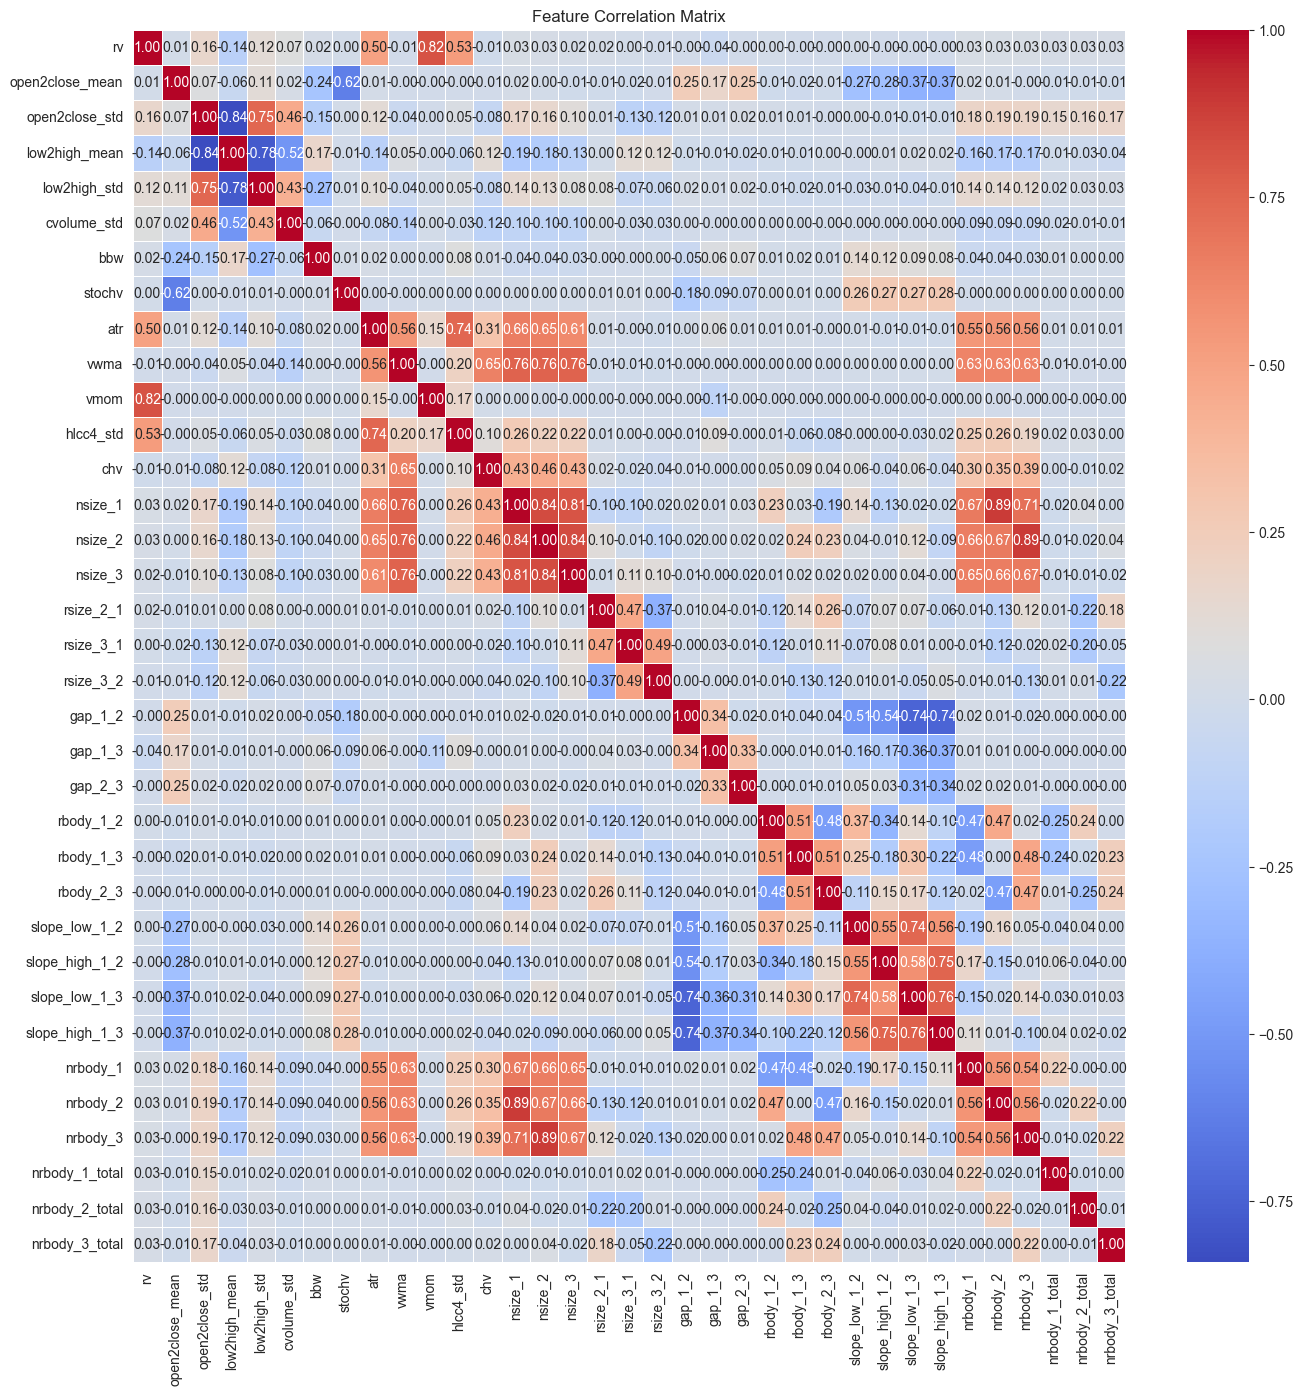

In [83]:
plt.figure(figsize=(16, 16))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [535]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=seed)

scaler = StandardScaler()
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)

kf = KFold(n_splits=5, shuffle=True, random_state=seed)

fold_mse = []
fold_r2 = []
calibrators = []

for train_index, test_index in kf.split(X_train):
    X_tr, X_tst = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_tst = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_tst)

    rf_model.fit(X_train_scaled, y_tr)

    y_pred_raw = rf_model.predict(X_test_scaled)

    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(y_pred_raw, y_tst)
    calibrators.append(iso_reg)

    y_pred_calibrated = iso_reg.predict(y_pred_raw)

    mse = mean_squared_error(y_tst, y_pred_calibrated)
    r2 = r2_score(y_tst, y_pred_calibrated)

    fold_mse.append(mse)
    fold_r2.append(r2)

    print(f"Fold MSE: {mse:.6f}, Fold R2: {r2:.4f}")

print(f"\nAverage MSE across folds: {np.mean(fold_mse):.6f}")
print(f"Average R2 across folds: {np.mean(fold_r2):.4f}")


Fold MSE: 0.000000, Fold R2: 0.8190
Fold MSE: 0.000001, Fold R2: 0.9996
Fold MSE: 0.000000, Fold R2: 0.6085
Fold MSE: 0.035696, Fold R2: 0.3333
Fold MSE: 0.001263, Fold R2: 0.5000

Average MSE across folds: 0.007392
Average R2 across folds: 0.6521


In [536]:
rf_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
})

rf_imp = rf_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

rf_imp.head(10)

,feature,importance
0,vmom,0.262147
1,rv,0.162919
2,hlcc4_std,0.130497
3,dchw,0.096314
4,atr,0.026783
5,nrbody_3_total,0.025871
6,slope_low_1_2,0.023121
7,open2close_mean,0.021543
8,gap_2_3,0.018244
9,nrbody_2_total,0.018194


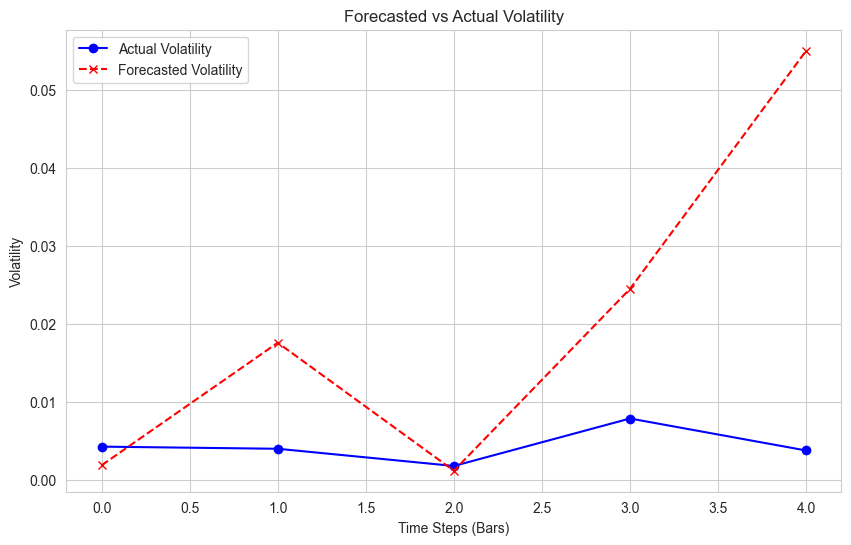

Mean Squared Error (MSE) for Volatility: 0.000618
R-squared (R2) for Volatility: -158.087698


In [537]:
forecast_steps = 5

last_data_point = X_test.iloc[-1].values.reshape(1, -1)
final_calibrator = calibrators[-1]

forecasted_squared_volatility = []
forecasted_intervals = []

non_conformity_scores = []

for i in range(forecast_steps):
    forecast_raw = rf_model.predict(last_data_point)
    forecast = final_calibrator.predict(forecast_raw)

    forecasted_squared_volatility.append(forecast[0])

    last_data_point = np.roll(last_data_point, shift=-1, axis=1)
    last_data_point[0, -1] = forecast[0]

forecasted_volatility = np.sqrt(forecasted_squared_volatility)
actual_squared_volatility = y_test.iloc[-forecast_steps:].values
actual_volatility = np.sqrt(actual_squared_volatility)

plt.figure(figsize=(10, 6))

plt.plot(range(forecast_steps), actual_volatility, label='Actual Volatility', color='blue', marker='o')
plt.plot(range(forecast_steps), forecasted_volatility, label='Forecasted Volatility', color='red', linestyle='--', marker='x')

plt.title('Forecasted vs Actual Volatility')
plt.xlabel('Time Steps (Bars)')
plt.ylabel('Volatility')
plt.legend()

plt.show()

mse_volatility = mean_squared_error(actual_volatility, forecasted_volatility)
r2_volatility = r2_score(actual_volatility, forecasted_volatility)

print(f'Mean Squared Error (MSE) for Volatility: {mse_volatility:.6f}')
print(f'R-squared (R2) for Volatility: {r2_volatility:.6f}')


In [84]:
from sklearn.covariance import GraphicalLasso
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR


def get_adj(X, method="glasso", alpha=0.1, lag_order=3, H=5, threshold_quantile=0.75):
    X_scaled = StandardScaler().fit_transform(X)

    if method == "glasso":
        glasso = GraphicalLasso(alpha=alpha)
        glasso.fit(X_scaled)
        precision_matrix = glasso.precision_

        threshold = np.quantile(np.abs(precision_matrix), threshold_quantile)
        adj = (np.abs(precision_matrix) > threshold).astype(float)

    elif method == "spillover":
        model = VAR(X_scaled)
        results = model.fit(maxlags=lag_order)

        fevd = results.fevd(H)
        spillover_matrix = fevd.decomp
        spillover_matrix /= spillover_matrix.sum(axis=2, keepdims=True)

        n = spillover_matrix.shape[0]
        spillover_index = np.zeros((n, n))

        for h in range(H):
            spillover_index += spillover_matrix[:, h, :]

        threshold = np.quantile(spillover_index, threshold_quantile)
        adj = (spillover_index > threshold).astype(float)

    else:
        raise ValueError("Invalid method. Choose 'glasso' or 'spillover'.")


    np.fill_diagonal(adj, 0)

    return adj

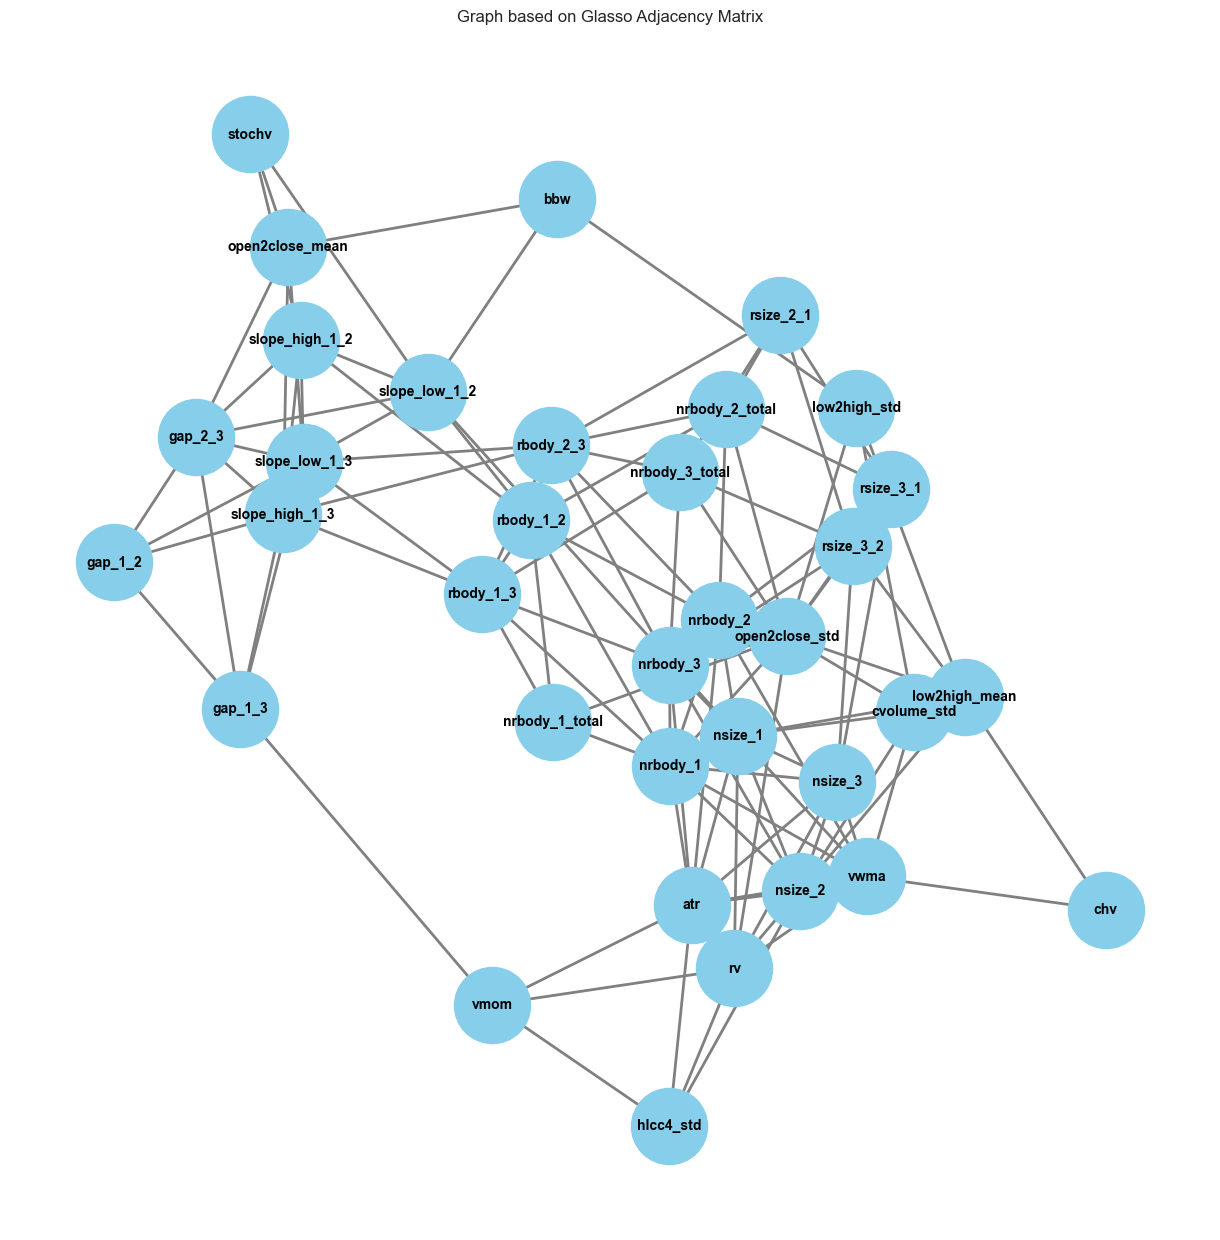

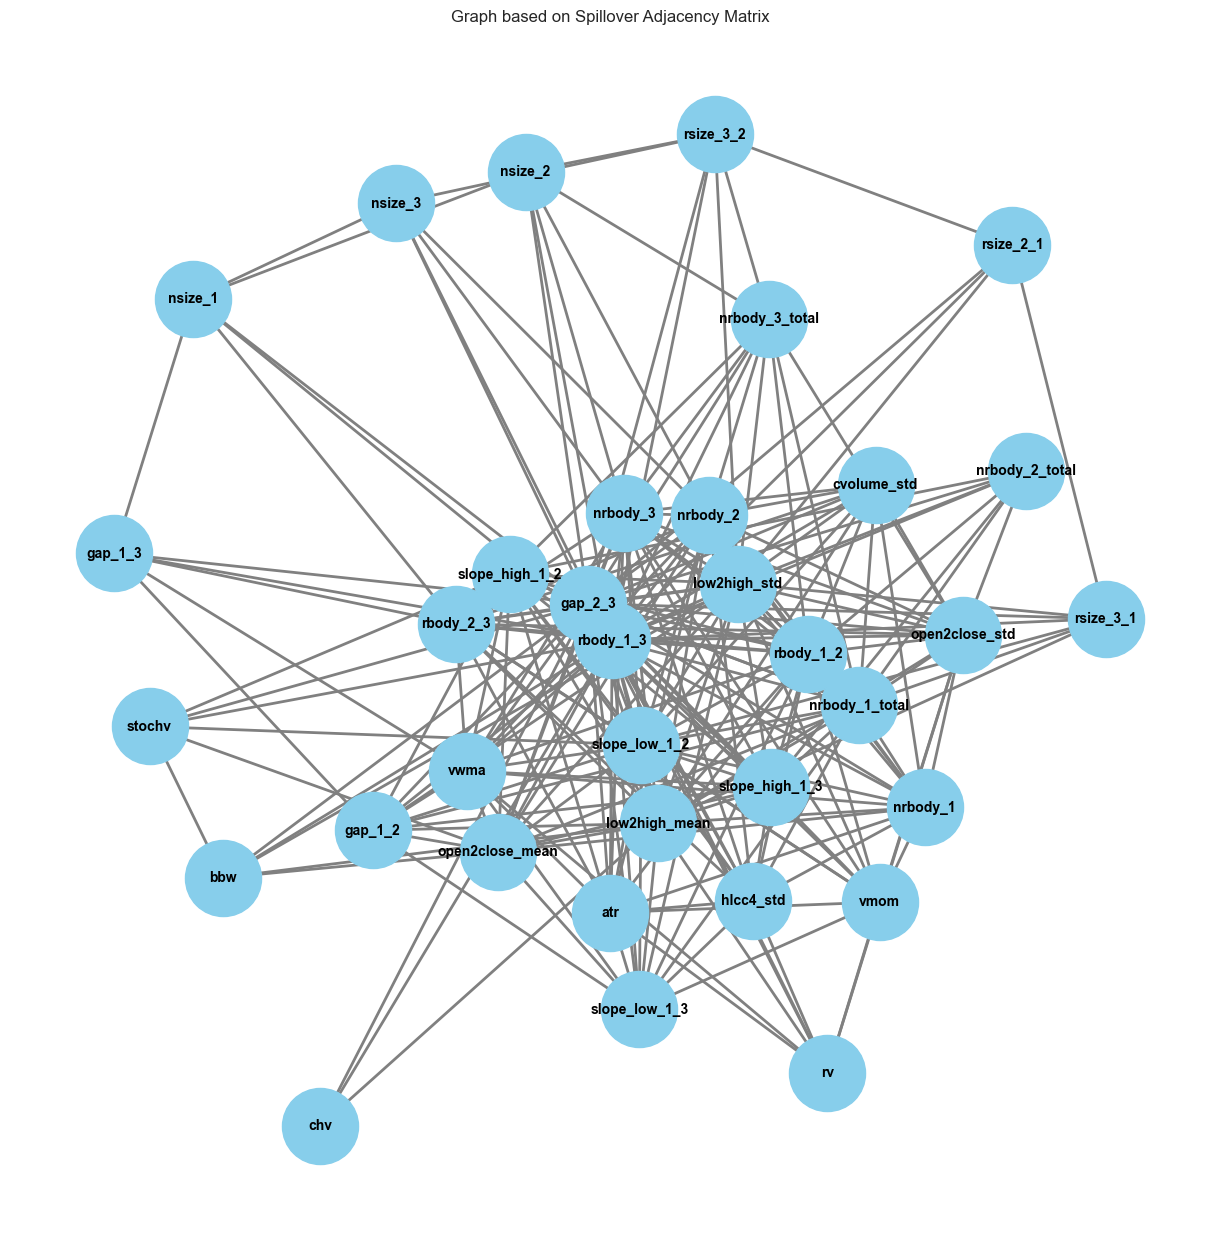

In [85]:
import networkx as nx
from scipy.sparse import csr_matrix
from torch_geometric.utils import from_scipy_sparse_matrix

methods = ['glasso', 'spillover']

for method in methods:
    adj = get_adj(X, method=method)

    edge_index, edge_attr = from_scipy_sparse_matrix(csr_matrix(adj))

    GGlasso = nx.Graph()

    GGlasso.add_nodes_from(features)

    for i, (src, dest) in enumerate(edge_index.t().numpy()):
        weight = edge_attr[i].item()
        GGlasso.add_edge(features[src], features[dest], weight=weight)

    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(GGlasso, seed=seed)
    nx.draw(GGlasso, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=2)

    plt.title(f"Graph based on {method.capitalize()} Adjacency Matrix")
    plt.show()

In [128]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

def create_dataloader(X, y, method='spillover', batch_size=16):
    X = X.copy()
    y = y.copy()
    
    adj = get_adj(X, method=method)
    edge_index, edge_attr = from_scipy_sparse_matrix(csr_matrix(adj))

    data_list = []

    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values
    
    for i in range(0, X.shape[0], batch_size):
        batch_features = X[i:i + batch_size]
        batch_targets = y[i:i + batch_size]

        y_25 = np.percentile(batch_targets, 25)
        y_75 = np.percentile(batch_targets, 75)

        for j in range(batch_features.shape[0]):
            xt = torch.tensor(batch_features[j], dtype=torch.float32).unsqueeze(0)
            yt = torch.tensor(batch_targets[j], dtype=torch.float32)
            yt_q25 = torch.tensor([y_25], dtype=torch.float32)
            yt_q75 = torch.tensor([y_75], dtype=torch.float32)


            data = Data(x=xt, edge_index=edge_index, edge_attr=edge_attr, y=yt, y_q25=yt_q25, y_q75=yt_q75)
            data_list.append(data)

    dataloader = DataLoader(data_list, batch_size=1, shuffle=True)

    return dataloader
    

In [129]:
dataloader = create_dataloader(X, y, method='spillover', batch_size=16)
batch = next(iter(dataloader))
batch

DataBatch(x=[1, 35], edge_index=[2, 274], edge_attr=[274], y=[1], y_q25=[1], y_q75=[1], batch=[1], ptr=[2])

In [130]:
print("x shape:", batch.x.shape)
print("edge_index shape:", batch.edge_index.shape)
print("edge_index max:", batch.edge_index.max().item())

x shape: torch.Size([1, 35])
edge_index shape: torch.Size([2, 274])
edge_index max: 34


In [102]:
class TPG(nn.Module):
    def __init__(self, feature_dim, adj_dim, hidden_dim, output_dim, num_heads=4):
        super(TPG, self).__init__()

        self.gcn1_features = gnn.GCNConv(feature_dim, hidden_dim)
        self.gat1_features = gnn.GATv2Conv(hidden_dim, hidden_dim // num_heads, heads=num_heads)
        self.fc1_features = nn.Linear(hidden_dim, hidden_dim)

        self.gcn2_adj = gnn.GCNConv(adj_dim, hidden_dim)
        self.gat2_adj = gnn.GATv2Conv(hidden_dim, hidden_dim // num_heads, heads=num_heads)
        self.fc2_adj = nn.Linear(hidden_dim, hidden_dim)

        self.fc_combined = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.fc_q25 = nn.Linear(hidden_dim, 1)
        self.fc_q75 = nn.Linear(hidden_dim, 1)

        self.activation = nn.ReLU()

    def forward(self, x, adj, edge_index, edge_attr=None):
        gcn1_out_features = self.activation(self.gcn1_features(x, edge_index))
        gat1_out_features = self.activation(self.gat1_features(gcn1_out_features, edge_index, edge_attr))
        fc1_out_features = self.activation(self.fc1_features(gat1_out_features))

        gcn2_out_adj = self.activation(self.gcn2_adj(adj, edge_index))
        gat2_out_adj = self.activation(self.gat2_adj(gcn2_out_adj, edge_index, edge_attr))
        fc2_out_adj = self.activation(self.fc2_adj(gat2_out_adj))

        combined = torch.cat([fc1_out_features, fc2_out_adj], dim=-1)

        fc_combined_out = self.activation(self.fc_combined(combined))
        fc3_out = self.activation(self.fc3(fc_combined_out))

        q25_pred = self.fc_q25(fc3_out)
        q75_pred = self.fc_q75(fc3_out)

        return q25_pred, q75_pred


In [103]:
def quant_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    positive_error = quantile * error
    negative_error = (quantile - 1) * error

    loss = torch.where(error > 0, positive_error, negative_error)

    return loss.mean()

def combo_loss(y_true_q25, y_true_q75, q25_pred, q75_pred, alpha=1.0, beta=1.0):
    loss_q25 = quant_loss(y_true_q25, q25_pred, 0.25)
    loss_q75 = quant_loss(y_true_q75, q75_pred, 0.75)

    total_loss = alpha * loss_q25 + beta * loss_q75

    return total_loss


In [104]:
from notebooks.train import CheckPoint, EarlyStop, SnapshotManager

n_snapshots = 3
patience = 16
snapshot_interval = 5
epoch = 8

FEATURE = len(features)
ADJ = adj.shape[0]
HIDDEN = 64
OUTPUT = 2
LR = 0.0001

model_gvag = TPG(feature_dim=FEATURE, adj_dim=ADJ, hidden_dim=HIDDEN, output_dim=OUTPUT)
optimizer = torch.optim.Adam(model_gvag.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
criterion = None

snapshot_manager = SnapshotManager(model_gvag, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=patience)
checkpoint = CheckPoint(
    snapshot_manager=snapshot_manager, snapshot_interval=snapshot_interval
)

In [61]:
from notebooks.train import Trainer


class TPGTrainer(Trainer):
    def __init__(self, *args, acc_steps=4, **kwargs):
        super().__init__(*args, **kwargs)
        self.acc_steps = acc_steps

    def train_epoch(self):
        self.model.train()
        running_train_loss = 0.0
        num_batches = len(self.train_dataloader)
        acc_loss = 0.0

        for batch_idx, batch in enumerate(self.train_dataloader):
            x = batch[0].x.to(DEVICE)
            edge_index = batch[0].edge_index.to(DEVICE)
            edge_attr = batch[0].edge_attr.to(DEVICE)
            y_q25 = batch[0].y_q25.to(DEVICE)
            y_q75 = batch[0].y_q75.to(DEVICE)

            q25_pred, q75_pred = self.model(x=x, adj=adj, edge_index=edge_index, edge_attr=edge_attr)

            loss = combo_loss(
                y_true_q25=y_q25,
                y_true_q75=y_q75,
                q25_pred=q25_pred,
                q75_pred=q75_pred,
            )
            acc_loss += loss.item()

            loss.backward()

            if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                self.optimizer.step()
                self.optimizer.zero_grad()
                running_train_loss += acc_loss
                acc_loss = 0.0

        avg_train_loss = running_train_loss / max(1, (num_batches + self.acc_steps - 1) // self.acc_steps)

        return avg_train_loss

    def valid_epoch(self):
        return 0.0

In [105]:
trainer = TPGTrainer(
    model_gvag,
    dataloader,
    None,
    optimizer,
    scheduler,
    None,
    early_stop,
    checkpoint,
    device=DEVICE
)

No snapshots found, starting from scratch.


In [106]:
trainer.train(epoch)

Start training with epochs 8


RuntimeError: index 2 is out of bounds for dimension 0 with size 1

In [312]:
model_tpg_inf = TPG(feature_dim=FEATURE, adj_dim=ADJ, hidden_dim=HIDDEN, output_dim=OUTPUT)
model_tpg_inf.to(DEVICE)

snapshot_manager = SnapshotManager(model_tpg_inf)
snapshot_manager.load_latest()

Loaded snapshot: snapshots/GVAG_epoch_20_improved.pth


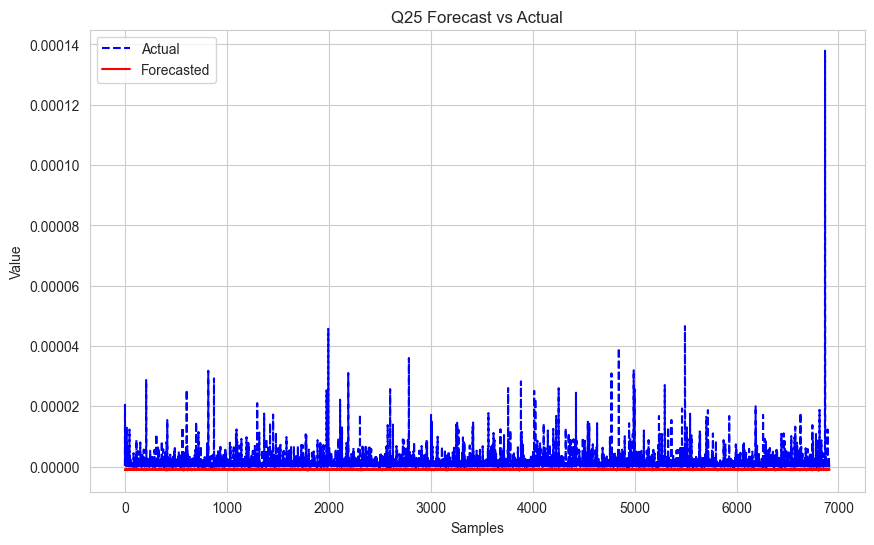

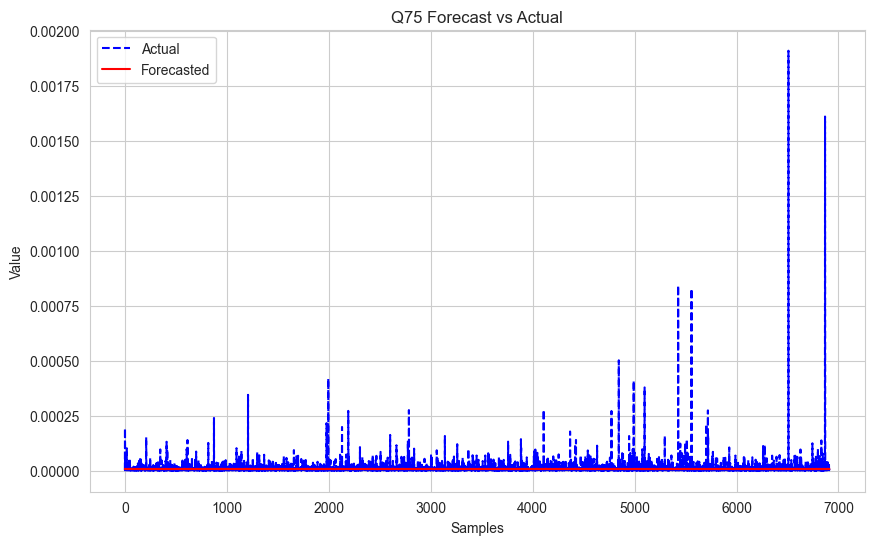

In [313]:
def test_forecast(model, test_loader, device=DEVICE):
    model.eval()

    actual_q25 = []
    actual_q75 = []
    forecasted_q25 = []
    forecasted_q75 = []

    with torch.no_grad():
        for batch in test_loader:
            x = batch[0].x.to(DEVICE)
            edge_index = batch[0].edge_index.to(DEVICE)
            edge_attr = batch[0].edge_attr.to(DEVICE)
            y_q25 = batch[0].y_q25.to(DEVICE)
            y_q75 = batch[0].y_q75.to(DEVICE)

            q25_pred, q75_pred = model(x=x, adj=adj, edge_index=edge_index, edge_attr=edge_attr)

            actual_q25.append(y_q25.cpu().numpy())
            actual_q75.append(y_q75.cpu().numpy())
            forecasted_q25.append(q25_pred.cpu().numpy())
            forecasted_q75.append(q75_pred.cpu().numpy())

    actual_q25 = np.concatenate(actual_q25, axis=0)
    actual_q75 = np.concatenate(actual_q75, axis=0)
    forecasted_q25 = np.concatenate(forecasted_q25, axis=0)
    forecasted_q75 = np.concatenate(forecasted_q75, axis=0)

    plot_forecast(actual_q25, forecasted_q25, title="Q25 Forecast vs Actual")
    plot_forecast(actual_q75, forecasted_q75, title="Q75 Forecast vs Actual")


def plot_forecast(actual, forecasted, title="Forecast vs Actual"):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label="Actual", color="blue", linestyle='dashed')
    plt.plot(forecasted, label="Forecasted", color="red", linestyle='solid')
    plt.xlabel("Samples")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


test_forecast(model_gvag_inf, test_loader, DEVICE)